In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns
from sklearn.cluster import KMeans

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import *
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()
# plt.rcParams['figure.dpi'] = 300


## Creating RecommenderSystem on MovieLens 

In [6]:
n_attrs=20
max_iter=1000
n_clusters=25

In [7]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

print(item_cluster_centers.shape)
print(user_cluster_centers.shape)

Loaded embeddings.
Loaded clusters.
Loaded clusters.
(25, 20)
(25, 20)


## Assigning Item Clusters to Users

In [8]:
# TODO: Test whether the closest cluster includes many of the items viewed by the user
user_to_item_cluster_assignment = user_topic_mapping(user_representation, item_cluster_centers)

## Cluster experiments

In [9]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import colorcet as cc
from scipy import interpolate
from scipy.spatial import ConvexHull

### Functions

In [10]:
# count number of occurences in cluster_ids
def plot_cluster_distributions(binary_ratings_matrix, user_cluster_ids, item_cluster_ids):
    fig, axs = plt.subplots(2,2, figsize=(15, 7))

    # plot bar chart where x axis is cluster_id and height is number of items in a cluster
    cluster_counts = np.bincount(user_cluster_ids)
    axs[0, 0].bar(x=range(len(cluster_counts)), height=cluster_counts)
    axs[0, 0].set_xticks(range(len(cluster_counts)), range(0, len(cluster_counts)))
    axs[0, 0].set_title('Users per cluster')

    # count number of occurences in cluster_ids
    cluster_counts = np.bincount(item_cluster_ids)
    axs[0, 1].bar(x=range(len(cluster_counts)), height=cluster_counts)
    axs[0, 1].set_xticks(range(len(cluster_counts)), range(0, len(cluster_counts)))
    axs[0, 1].set_title('Items per cluster')

    # Interactions per user cluster
    interactions_per_user_cluster = np.empty(len(np.unique(user_cluster_ids)), dtype=int)
    for i, id in enumerate(user_cluster_ids):
        interactions_per_user_cluster[id] += np.sum(binary_ratings_matrix[i, :])

    # Interactions per item cluster
    interactions_per_item_cluster = np.empty(len(np.unique(item_cluster_ids)), dtype=int)
    for i, id in enumerate(item_cluster_ids):
        interactions_per_item_cluster[id] += np.sum(binary_ratings_matrix[:, i])

    axs[1, 0].bar(x=range(len(interactions_per_user_cluster)), height=interactions_per_user_cluster)
    axs[1, 0].set_xticks(range(len(np.unique(user_cluster_ids))), range(0, len(np.unique(user_cluster_ids))))
    axs[1, 0].set_title('Interactions by User Cluster')

    axs[1, 1].bar(x=range(len(interactions_per_item_cluster)), height=interactions_per_item_cluster)
    axs[1, 1].set_xticks(range(len(np.unique(item_cluster_ids))), range(0, len(np.unique(item_cluster_ids))))
    axs[1, 1].set_title('Interactions by Item Cluster')

    plt.show()

### Visualize clusters prior to Simulation

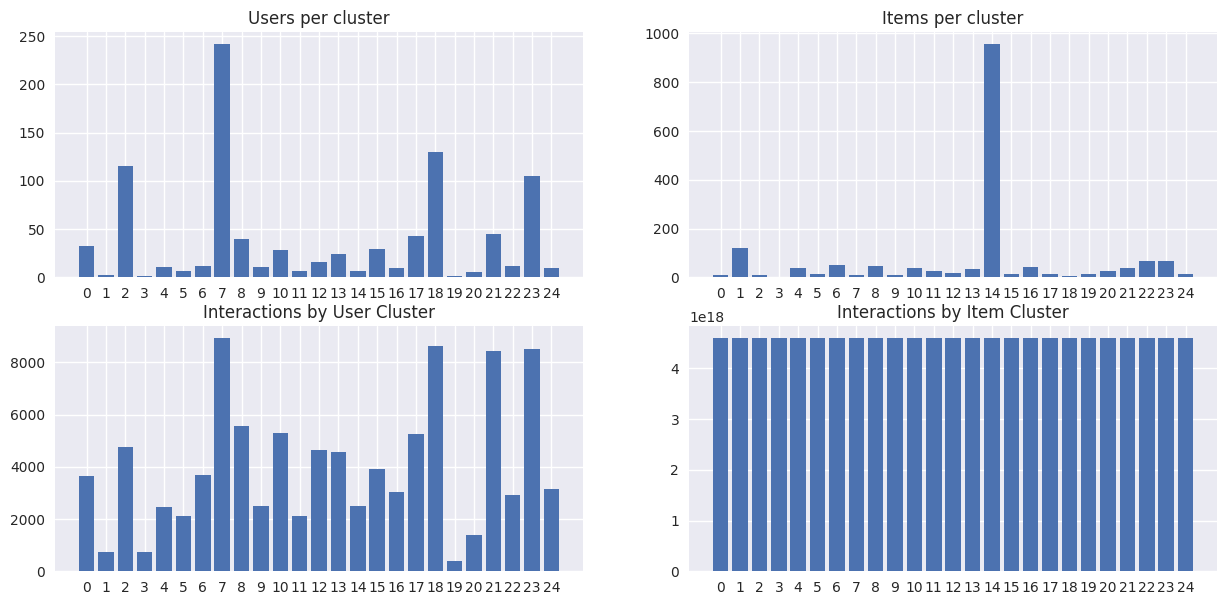

In [11]:
plot_cluster_distributions(binary_ratings_matrix, user_cluster_ids, item_cluster_ids)

In [12]:
# Using user representation and clusters from NMF to visualize user separation
x = user_representation
y = user_to_item_cluster_assignment
perplexity = 50

df_prev = apply_tsne_2d(x, y, perplexity=perplexity)

/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (9), which may not be intended.
  data=df).set(title="")


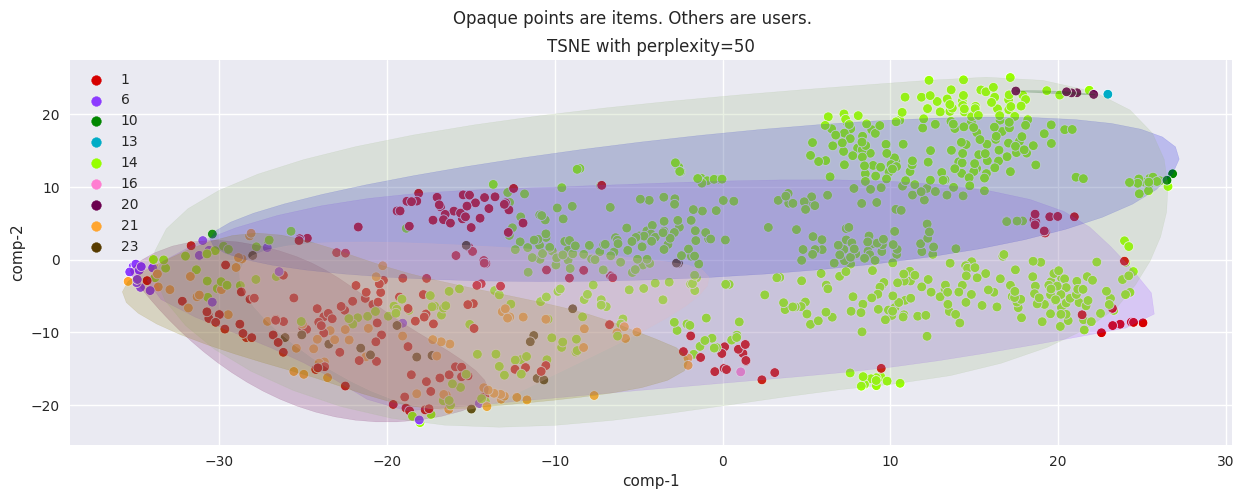

In [13]:
plot_tsne(df_prev, perplexity, n_clusters)

In [10]:
# Problems:
#   1. Matched user centroids to item centroids based on minimium euclidean distance 
#      -> only 5 item clusters are selected
#   2. Matched users to item centroids based on min. euclidean distance 
#      -> almost 800 users go to same item cluster
#   3. Generally, the data is very skewed (this is realistic but quickly assign most observations
#      to the same cluster)

### Visualize clusters post simulation

In [26]:
# Load preferences after model ran
pref_dir = 'artefacts/ablation_lambda_entropy/final_preferences/'

# Only compare ranking mechanisms with each other that have the same model parameters
n_attrs = n_attrs
n_clusters = n_clusters
train_timesteps = 10
run_timesteps = 100
drift = 0.05
attention_exp = -0.8

parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'

In [17]:
def load_final_preferences(config, parameters_str):
    file_prefix = f"{config['model_name']}_final_preferences"
    
    if config['requires_alpha']:
        parameters_str += f"_{config['alpha']}Lambda"

    # Load file
    path = pref_dir + file_prefix + parameters_str + '.npy'
    final_user_pref = np.load(path, allow_pickle=True)
    # Map users to the fixed item clusters based on their embedding distances to the item_cluster_centers
    final_user_pref_mapping = user_topic_mapping(final_user_pref, item_cluster_centers)
    
    return final_user_pref, final_user_pref_mapping

In [18]:
# Myopic
myopic_config = {
    'model_name': 'myopic',
    'requires_alpha': False,
}

myopic_final_user_pref, myopic_final_user_pref_mapping = load_final_preferences(myopic_config, parameters)

In [19]:
df_post = apply_tsne_2d(myopic_final_user_pref, myopic_final_user_pref_mapping, perplexity=perplexity)

In [20]:
diff_set = set(df_post.y.unique()) - set(df_prev.y.unique())

list(set(df_prev.y.unique())) + list(diff_set)

[1, 6, 10, 13, 14, 16, 20, 21, 23, 4, 8, 11, 12, 17, 22, 24]

/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (9), which may not be intended.
  data=df).set(title="")
/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (16), which may not be intended.
  data=df).set(title="")


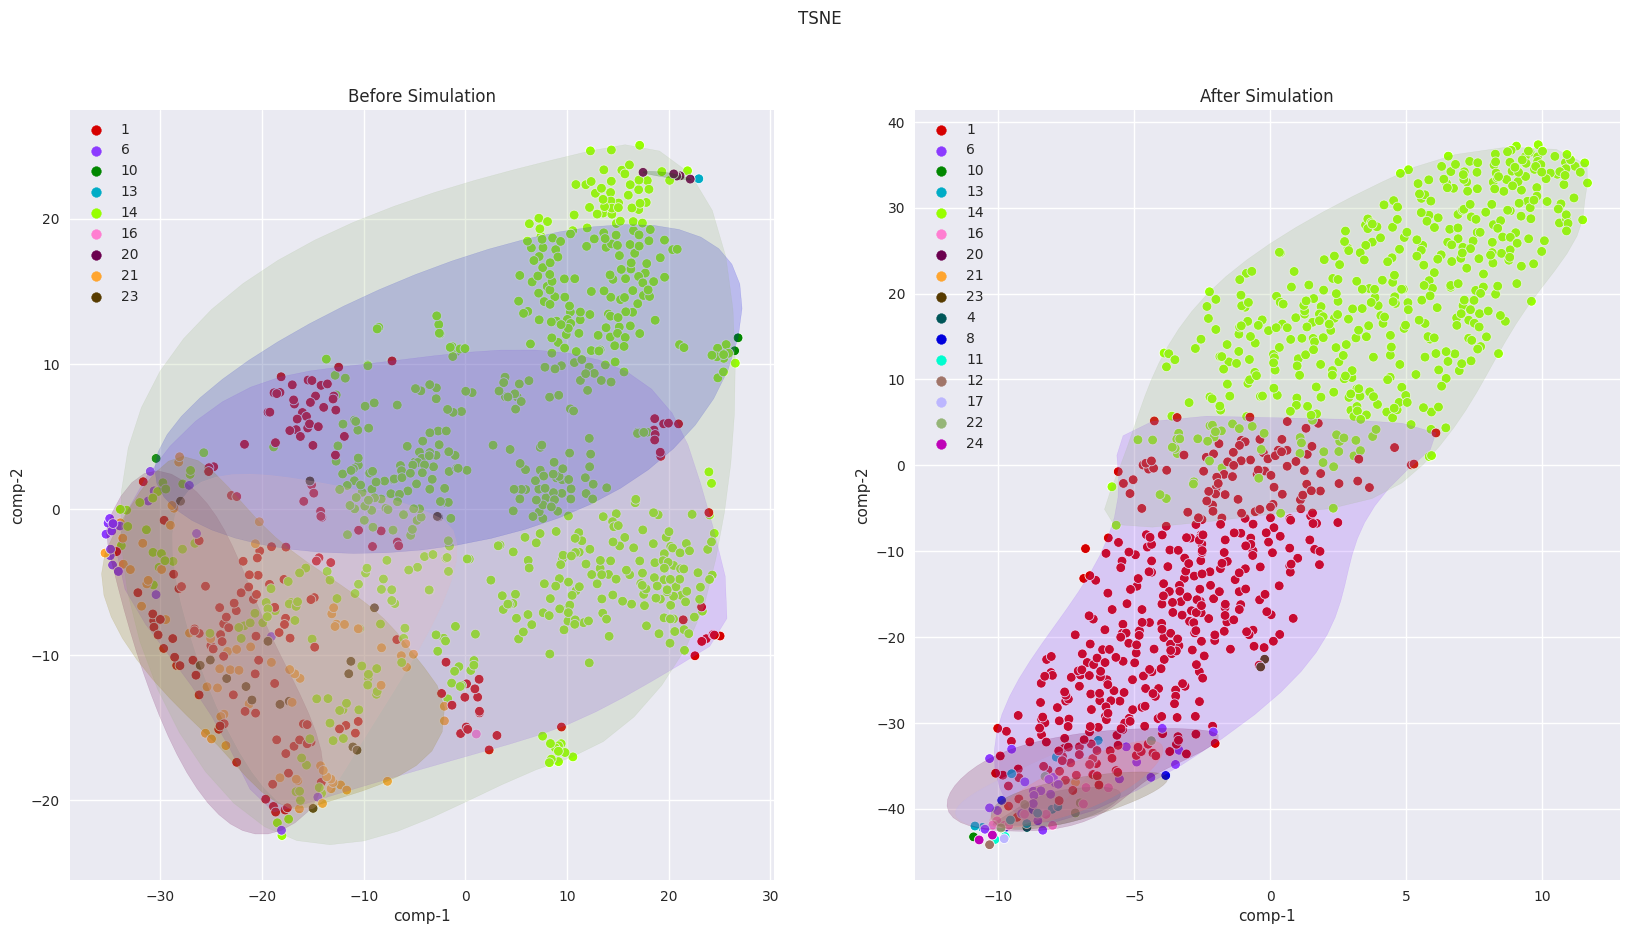

In [21]:
import src
reload(src)
reload(src.plotting)
from src.plotting import *
plot_tsne_comparison(df_prev, df_post, n_clusters)

In [22]:
def calculate_cluster_switch(user_to_item_cluster_assignment, final_user_pref_mapping, config):
    data = []
    data.append(user_to_item_cluster_assignment)
    data.append(final_user_pref_mapping)
    data = np.array(data).T
    cluster_changes_df = pd.DataFrame(data, columns=['initial_cluster', 'final_cluster'])
    cluster_changes_df = cluster_changes_df[cluster_changes_df['initial_cluster'] != cluster_changes_df['final_cluster']]
    print(config['model_name'], ': Number of people who changed clusters: ', cluster_changes_df.shape[0])

calculate_cluster_switch(user_to_item_cluster_assignment, myopic_final_user_pref_mapping, myopic_config)

myopic : Number of people who changed clusters:  336


In [23]:
def average_distance_other_clusters(user_profiles, item_cluster_centers):
    euclidean_distance_matrix = np.empty((len(user_profiles), len(item_cluster_centers)), dtype=float)
    for i, user in enumerate(user_profiles):
        for j, item_cluster in enumerate(item_cluster_centers):
            euclidean_distance_matrix[i, j] = np.linalg.norm(user - item_cluster)

    user_to_item_cluster_assignment = np.argmin(euclidean_distance_matrix, axis=1)
    
    # calculate average of distances to other clusters
    for user, cluster in enumerate(user_to_item_cluster_assignment):
        euclidean_distance_matrix[user, cluster] = np.nan
    
    mean_diff = np.nanmean(euclidean_distance_matrix)

    return mean_diff

print('before:', average_distance_other_clusters(user_representation, item_cluster_centers))
print('after:', average_distance_other_clusters(myopic_final_user_pref, item_cluster_centers))

before: 2.3625628242698875
after: 2.2614452874546678


In [28]:
# Entropy
entropy_config = {
    'model_name': 'entropy',
    'requires_alpha': True,
    'alpha': 1.0,
}

entropy_final_user_pref, entropy_final_user_pref_mapping = load_final_preferences(entropy_config, parameters)

df_post = apply_tsne_2d(entropy_final_user_pref, entropy_final_user_pref_mapping, perplexity=perplexity)

/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (9), which may not be intended.
  data=df).set(title="")
/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (13), which may not be intended.
  data=df).set(title="")


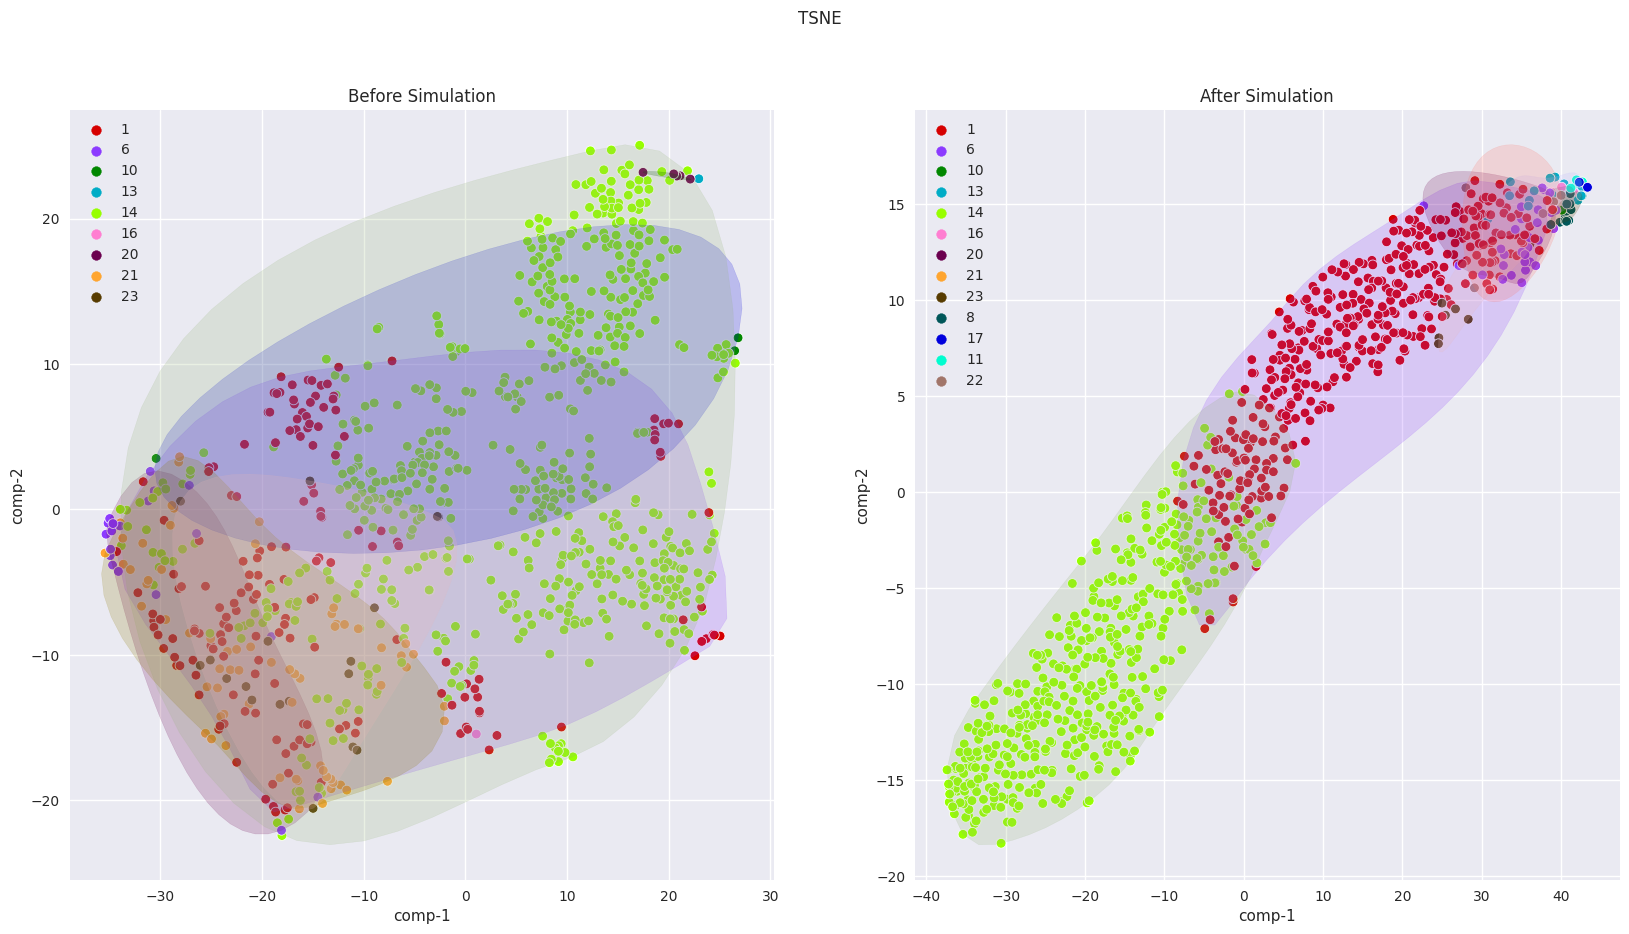

entropy : Number of people who changed clusters:  341
before: 2.3625628242698875
after: 2.256905805553604


In [29]:
plot_tsne_comparison(df_prev, df_post, n_clusters)
calculate_cluster_switch(user_to_item_cluster_assignment, entropy_final_user_pref_mapping, entropy_config)

print('before:', average_distance_other_clusters(user_representation, item_cluster_centers))
print('after:', average_distance_other_clusters(entropy_final_user_pref, item_cluster_centers))

/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (9), which may not be intended.
  data=df).set(title="")
/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (12), which may not be intended.
  data=df).set(title="")


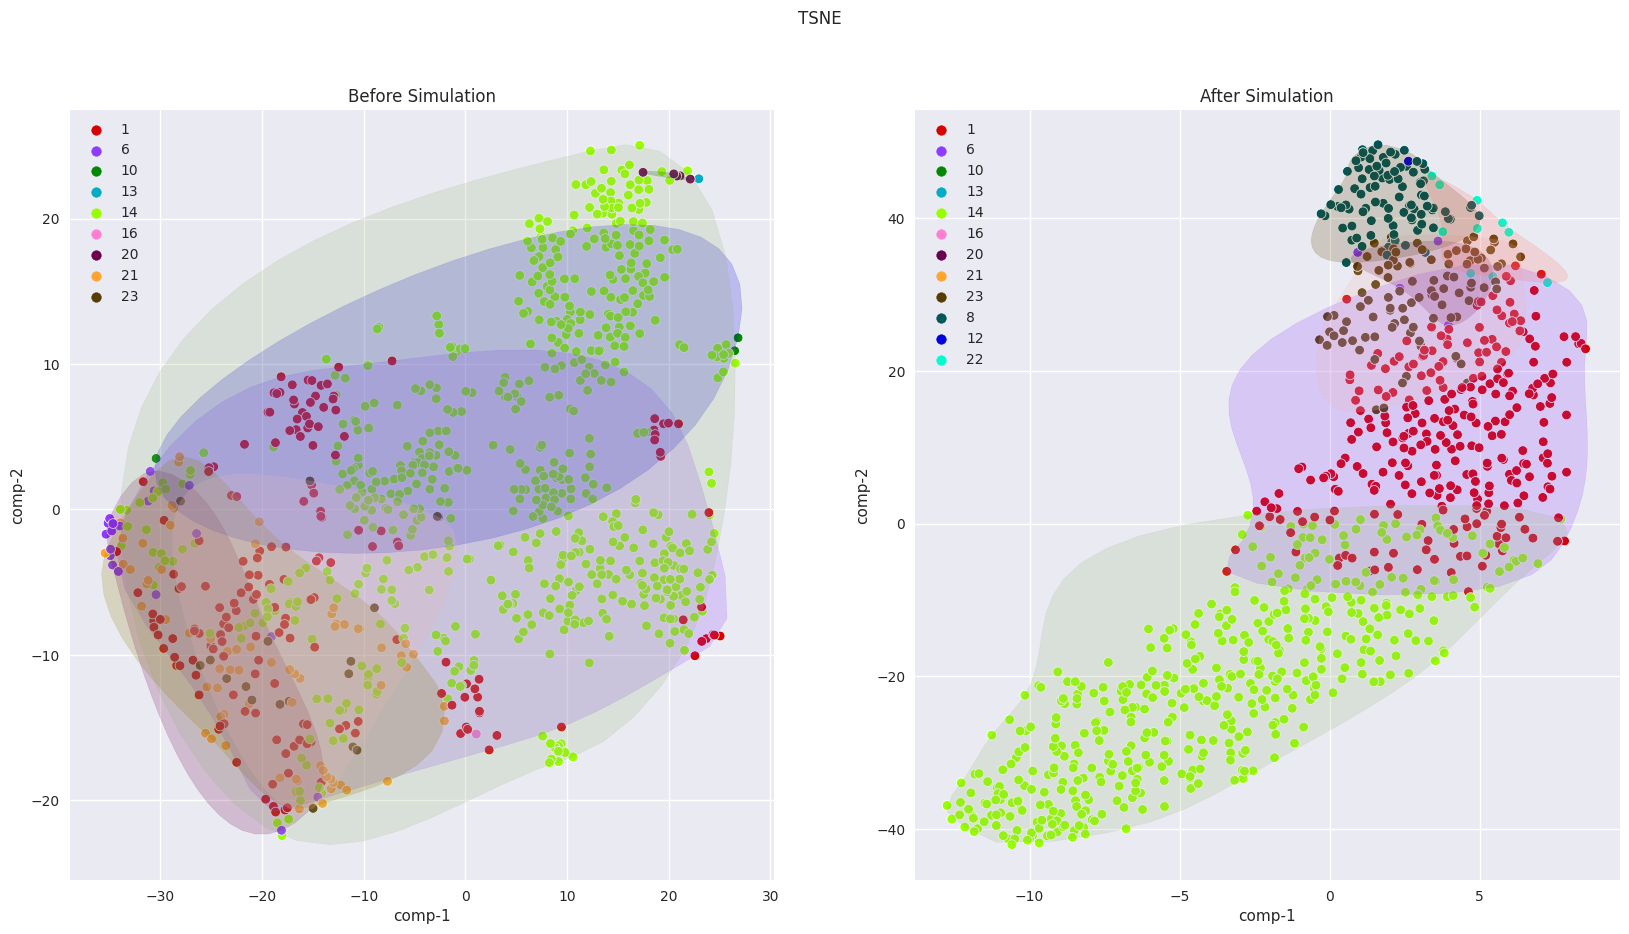

cosine_sim : Number of people who changed clusters:  396
before: 2.3625628242698875
after: 2.2238485326254924


In [24]:
# Cosine Sim
cosine_config = {
    'model_name': 'cosine_sim',
    'requires_alpha': True,
    'alpha': 0.1,
}

cosine_final_user_pref, cosine_final_user_pref_mapping = load_final_preferences(cosine_config, parameters)

df_post = apply_tsne_2d(cosine_final_user_pref, cosine_final_user_pref_mapping, perplexity=perplexity)

plot_tsne_comparison(df_prev, df_post, n_clusters)
calculate_cluster_switch(user_to_item_cluster_assignment, cosine_final_user_pref_mapping, cosine_config)

print('before:', average_distance_other_clusters(user_representation, item_cluster_centers))
print('after:', average_distance_other_clusters(cosine_final_user_pref, item_cluster_centers))

/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (9), which may not be intended.
  data=df).set(title="")
/home/jjw2196/fair-recommender-systems/src/plotting.py:139: UserWarning: The palette list has more values (25) than needed (15), which may not be intended.
  data=df).set(title="")


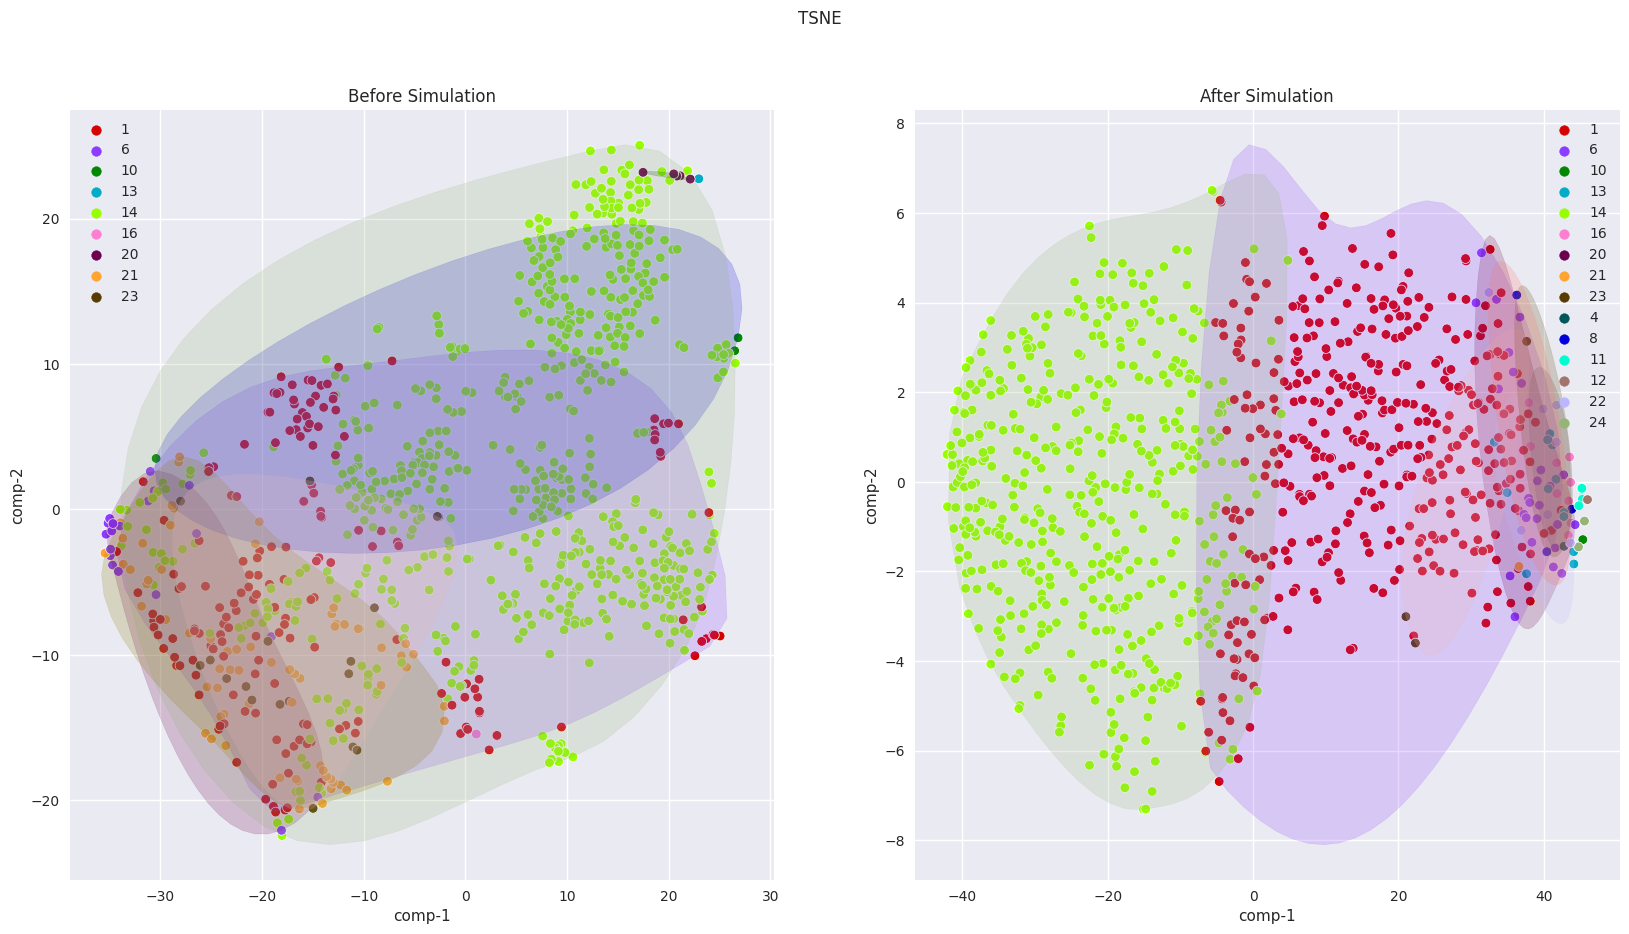

top_k_reranking : Number of people who changed clusters:  336
before: 2.3625628242698875
after: 2.2615409891778855


In [25]:
# Cosine Sim
top_k_config = {
    'model_name': 'top_k_reranking',
    'requires_alpha': False,
}

top_k_final_user_pref, top_k_final_user_pref_mapping = load_final_preferences(top_k_config, parameters)

df_post = apply_tsne_2d(top_k_final_user_pref, top_k_final_user_pref_mapping, perplexity=perplexity)

plot_tsne_comparison(df_prev, df_post, n_clusters)
calculate_cluster_switch(user_to_item_cluster_assignment, top_k_final_user_pref_mapping, top_k_config)

print('before:', average_distance_other_clusters(user_representation, item_cluster_centers))
print('after:', average_distance_other_clusters(top_k_final_user_pref, item_cluster_centers))